## Application of Random Forest to AI Accelerometer data stream

This code is based on the random forest ipython notebook generated by KJ for the October, 2021 analysis of EPRI Flow Data. The version here is meant to process AI Accelerometer data and look for the changes to the data stream produced by physical anomalies, as indicated by the notebook provided by Lea Boche and Christina Lawson (EPRI). 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble  import RandomForestClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score, mean_squared_error, r2_score, accuracy_score, confusion_matrix, classification_report, plot_confusion_matrix, make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn import tree
from sklearn.preprocessing import StandardScaler


import sys
from custom_metric import *

pd.set_option("display.max.columns", None)

In [2]:
# reading in the accelerometer data, note that the 'RealValue' column is the one to look at
df1 = pd.read_csv('20220726 eidb.csv')
df1['Date_Time'] =  pd.to_datetime(df1['Date_Time'])

# Xifan has manually entered the times when anomalies were triggered in the flow loop data for 2022-07-20
event_dic = {
    'power_on_off': ['2022-07-15 10:35:00', '2022-07-15 10:44:00'],
    'instrument_air_close_open': ['2022-07-15 10:54:00', '2022-07-15 10:59:00'],
    'HV_201_open_close': ['2022-07-15 12:35:00', '2022-07-15 12:45:00'],
    'HV_101_open_close': ['2022-07-15 12:46:00', '2022-07-15 12:53:00'],
    'LCV_203_air_close_open': ['2022-07-15 14:43:00', '2022-07-15 14:46:00'],
    'LCV_103_air_close_open': ['2022-07-15 14:48:00', '2022-07-15 14:50:00'],
    'SV_101_air_close_open': ['2022-07-15 14:50:00', '2022-07-15 14:53:00'],
    'SV_101_air_half_close_open': ['2022-07-15 14:53:00', '2022-07-15 14:55:00'],
    'SV_201_air_close_open': ['2022-07-15 14:55:00', '2022-07-15 14:57:00'],
    'P2_7gpm_P1_6.5gpm': ['2022-07-15 16:11:00', '2022-07-15 16:11:00']
}

In [3]:
print(df1['Date_Time'])

0       2022-07-08 18:59:13
1       2022-07-08 18:59:13
2       2022-07-08 18:59:13
3       2022-07-08 18:59:13
4       2022-07-08 18:59:13
                ...        
26176   2022-07-26 10:09:36
26177   2022-07-26 10:09:36
26178   2022-07-26 10:09:36
26179   2022-07-26 10:09:36
26180   2022-07-26 10:09:36
Name: Date_Time, Length: 26181, dtype: datetime64[ns]


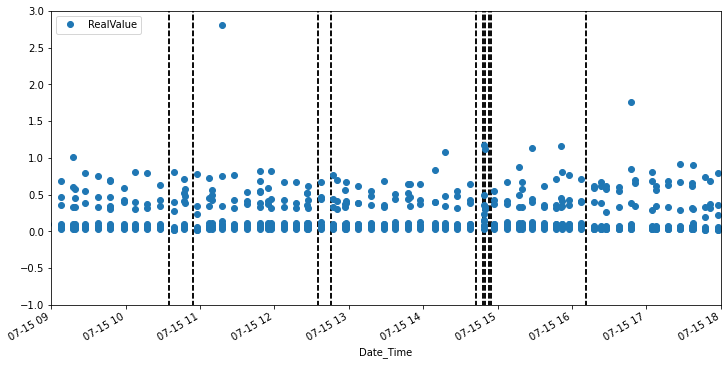

In [4]:
# see if there are any clear correlations betweem the anomalies and the changes to the accelerometer signal 
plt.rcParams['figure.figsize'] = [12, 6]
df1.plot(x='Date_Time', y='RealValue', marker="o",linestyle='None') 
plt.xlim(["2022-07-15 9:00", "2022-07-15 18:00"])
plt.ylim([-1, 3])

for key in event_dic.keys():
    event_begin = pd.to_datetime(event_dic[key][0])
    event_end = pd.to_datetime(event_dic[key][1])
    plt.vlines([event_begin, event_begin], -2, 8, colors='black', linestyles='dashed' )
plt.show()

In [5]:
# add a new column to the data frame so that anomalies appear as binary 1 yes/0 no anomaly
# we can then use this for the Random Forest
df1['bin_anomaly'] = 0
df1['anom_type'] = 'None'

for index in df1.index:
    time = df1['Date_Time'][index]
    for key in event_dic.keys():
        event_begin = pd.to_datetime(event_dic[key][0])
        event_end = pd.to_datetime(event_dic[key][1])
        if (time >= event_begin and time < event_end): 
            df1.at[index,'bin_anomaly'] = 1
            df1.at[index,'anom_type'] = key


In [6]:
df1.head()

,ID,Date_Time,PointIndex,Axis,Units,Severity,RealValue,FileID,Reason,SyncID,bin_anomaly,anom_type
0,1,2022-07-08 18:59:13,1,1,2,2.017857,1.150000,-1,7,NaN,0,None
1,2,2022-07-08 18:59:13,1,2,2,1.383929,0.430000,-1,7,NaN,0,None
2,3,2022-07-08 18:59:13,1,3,2,1.250000,0.280000,-1,7,NaN,0,None
3,4,2022-07-08 18:59:13,1,1,0,-1.000000,0.072792,1,1,NaN,0,None
4,5,2022-07-08 18:59:13,1,1,2,1.718162,0.804342,1,1,NaN,0,None


## Random Forest binary approach to classification of anomalies

In [7]:
drop_list = ['ID', 'Date_Time', 'PointIndex','Axis', 'Units','FileID', 'Reason', 'SyncID', 'anom_type']

value = 'bin_anomaly'
print(df1['bin_anomaly'].describe())

count    26181.000000
mean         0.001948
std          0.044094
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: bin_anomaly, dtype: float64


In [8]:
# Begin with binary classification approach

scaler = StandardScaler()  
#drop the columns we don't need
df = df1.drop(drop_list, axis=1)
    
#define features and value
X = df.drop(value, axis=1)
y = df[value]
    
    
#create train and test datasets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.20, random_state = 100)
    
#train the model
model = RandomForestClassifier(random_state = 100)
    
model.fit(X_train,y_train)
    
    
#calculate accuracy
predict_train = model.predict(X_train)
predict_val = model.predict(X_val)
accuracy_train = accuracy_score(y_train,predict_train)
print("Accuracies")
print('accuracy_score on train dataset : ', accuracy_train)
accuracy_val = accuracy_score(y_val,predict_val)
print('accuracy_score on test dataset : ', accuracy_val)
print('\n')
    
    
#calculate feature importances
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(model.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False)
print('Importances')
print(importances)
print('\n')

Accuracies
accuracy_score on train dataset :  0.999570282658518
accuracy_score on test dataset :  0.9982814588504869


Importances
     feature  importance
1  RealValue       0.668
0   Severity       0.332




In [9]:
model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 100,
 'verbose': 0,
 'warm_start': False}

In [11]:
#model hypertuning

# Number of trees in random forest
n_estimators = [50,75,100]

# Number of features to consider at every split; REMEMBER TO CHANGE THIS WHEN MORE FEATURES ARE PRESENT
max_features = [1,2]

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 20, 50]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the grid
search_params = {'n_estimators': n_estimators,
                 'max_features': max_features,
                 'min_samples_split': min_samples_split,
                 'bootstrap': bootstrap}

cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=100)

#perform model hypertuning

model_v2 = GridSearchCV(model, search_params, cv=cv, n_jobs=-1)

model_v2.fit(X_train, y_train)

best_params = model_v2.best_params_

print('Best Parameters: ', model_v2.best_params_)

print('Best score: ', model_v2.best_score_)

Best Parameters:  {'bootstrap': True, 'max_features': 2, 'min_samples_split': 50, 'n_estimators': 50}
Best score:  0.9968250179040343


In [12]:
#train the hypetuned model

model_v3 = RandomForestClassifier(random_state = 100, bootstrap = 'False', min_samples_split=5, max_features=2, n_estimators = 50)
model_v3.fit(X_train, y_train)

#perform cross validation
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=100)
scores = cross_val_score(model_v3, X, y, cv=cv, n_jobs=-1)
 
print('Cross Validation accuracy scores: %s' % scores)
 
print('Cross Validation accuracy: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))

Cross Validation accuracy scores: [0.99847241 0.99618102 0.99675387 0.99637197 0.99675387 0.99637197
 0.99694482 0.99618102 0.99713576 0.99656292]
Cross Validation accuracy: 0.997 +/- 0.001


In [13]:
#perform cross validation
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=100)
scores = cross_val_score(model_v3, X, y, cv=cv, n_jobs=-1, scoring=make_scorer(cedric_metric_binary, greater_is_better=True))
 
print('Cross Validation accuracy scores: %s' % scores)
 
print('Cross Validation accuracy: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))

Cross Validation accuracy scores: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Cross Validation accuracy: 0.000 +/- 0.000


Importances
     feature  importance
1  RealValue       0.674
0   Severity       0.326


Classification report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5231
           1       0.00      0.00      0.00         6

    accuracy                           1.00      5237
   macro avg       0.50      0.50      0.50      5237
weighted avg       1.00      1.00      1.00      5237





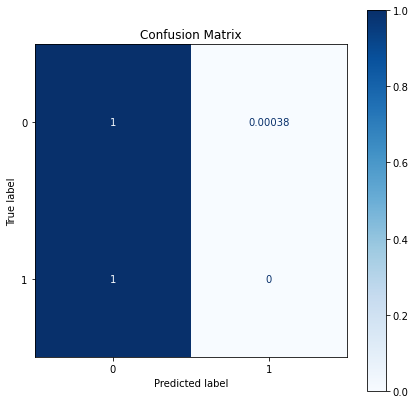

In [14]:
#calculate feature importances
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(model_v3.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False)
print('Importances')
print(importances)
print('\n')  
    
#print classification report
print('Classification report')
predict_val = model_v3.predict(X_val)
print(classification_report(y_val, predict_val))
print('\n')
    
#print normalized confusion matrix   
matrix = plot_confusion_matrix(model_v3, X_val, y_val, cmap=plt.cm.Blues, normalize='true')
matrix.ax_.set_title('Confusion Matrix')
fig = plt.gcf()
fig.set_size_inches(7, 7)
plt.show()